# Exploration of data from Jérémie

In [15]:
from matplotlib import pylab as plt
%matplotlib inline
from astropy.table import Table
import numpy as np
import pandas as pd

We will use Pandas to work with the data, but Pandas doesn't read FITS files, so we first we load the file with astropy.table, and then use the `to_pandas` method to convert it

In [16]:
dat = Table.read("score_gamma_all.fits")

first, we will add a new column that fixes the range of the `hillas_theta` column (until this is fixed in the code)

In [17]:
def ang(theta):
    return 90-(abs(abs(theta)-90))

In [18]:
dat['delta_theta'] = ang(dat['hillas_theta'])

The file contains: for each row, a method (corresponding to the name of the JSON input file), a telescope ID and an event ID, and all 3 are indices.  What we want is to split this into two tables (one for wavelets and one for tailcuts), and make join them side-by-side, so we can compare the results for each using the (telescope ID, event ID) as the join field

First we find what methods are in the file

In [19]:
np.unique(dat['JSON input file'])

score_gamma_all_tailcut_ref.json
score_gamma_all_wavelets_mrfilter_c2.json
score_gamma_all_wavelets_mrfilter_c2_kill.json
score_gamma_all_wavelets_mrfilter_kill.json
score_gamma_all_wavelets_mrfilter_kill_offset.json
score_gamma_all_wavelets_mrfilter_ref.json


we will select two methods: 
* score_gamma_all_tailcut_ref for tailcuts
* score_gamma_all_wavelets_mrfilter_kill for wavelets

In [20]:
T = dat[dat['JSON input file'] == 'score_gamma_all_tailcut_ref.json']
W = dat[dat['JSON input file'] == 'score_gamma_all_wavelets_mrfilter_kill.json']

>  ** note **
>  this could probably  be better done with a pivot table or something like that (maybe a `Panel` or `xray`), so we can explore *all* methods in  the file, but I couldn't figure out the right way to do it

now there are two tables, with each method. Let's conver them to Pandas DataFrames

In [21]:
PT = T.to_pandas()
PW = W.to_pandas()
PT.head()

,JSON input file,Event ID,Tel ID,NPE,FITS input file,Execution time,EV count,MC energy,mC energy unit,MC altitude,...,mse,nrmse,e_shape,e_energy,sspd,ssim,psnr,hillas_theta,hillas_theta2,delta_theta
0,score_gamma_all_tailcut_ref.json,507,1,158.0,/Users/jdecock/astri_data/fits/gamma/run1001.s...,0.046661,2,0.563842,TeV,1.22173,...,0.110820,0.281185,0.000285,0.094697,-0.094697,0.913843,69.553825,-161.401135,1.974528,18.598865
1,score_gamma_all_tailcut_ref.json,1909,1,150.0,/Users/jdecock/astri_data/fits/gamma/run1001.s...,0.030803,9,1.624136,TeV,1.22173,...,0.312471,1.122855,0.000950,0.731531,-0.731531,0.860696,65.051909,30.512330,30.273744,30.512330
2,score_gamma_all_tailcut_ref.json,2403,1,108.0,/Users/jdecock/astri_data/fits/gamma/run1001.s...,0.028216,11,0.934299,TeV,1.22173,...,0.157841,0.675705,0.000613,0.416432,-0.416432,0.925307,68.017796,10.429362,13.423561,10.429362
3,score_gamma_all_tailcut_ref.json,3005,1,129.0,/Users/jdecock/astri_data/fits/gamma/run1001.s...,0.028117,15,0.433240,TeV,1.22173,...,0.141086,0.391378,0.000591,0.444557,-0.444557,0.906877,68.505175,28.300363,29.731791,28.300363
4,score_gamma_all_tailcut_ref.json,3503,1,69.0,/Users/jdecock/astri_data/fits/gamma/run1001.s...,0.028921,21,0.264430,TeV,1.22173,...,0.041547,0.329841,0.000344,0.142090,-0.142090,0.950011,73.814635,5.853787,4.532323,5.853787


Finally, we want to join the tables together, and rename the columns such that the ones from Wavelets are suffixed by `_w` and for tailcuts by `_t`

In [22]:
wave = PW.set_index(['Tel ID','Event ID'])
tail = PT.set_index(['Tel ID','Event ID'])
wave.head()

JSON input file    NPE  \
Tel ID Event ID                                                       
1      507       score_gamma_all_wavelets_mrfilter_kill.json  158.0   
       1909      score_gamma_all_wavelets_mrfilter_kill.json  150.0   
       2403      score_gamma_all_wavelets_mrfilter_kill.json  108.0   
       3005      score_gamma_all_wavelets_mrfilter_kill.json  129.0   
       3503      score_gamma_all_wavelets_mrfilter_kill.json   69.0   

                                                   FITS input file  \
Tel ID Event ID                                                      
1      507       /Users/jdecock/astri_data/fits/gamma/run1001.s...   
       1909      /Users/jdecock/astri_data/fits/gamma/run1001.s...   
       2403      /Users/jdecock/astri_data/fits/gamma/run1001.s...   
       3005      /Users/jdecock/astri_data/fits/gamma/run1001.s...   
       3503      /Users/jdecock/astri_data/fits/gamma/run1001.s...   

                 Execution time  EV count  MC energy mC energy unit  \
Tel ID Event ID                                                       
1      507             0.619120         2   0.563842            TeV   
       1909            0.277836         9   1.624136            TeV   
       2403            0.262967        11   0.934299            TeV   
       3005            0.297770        15   0.433240            TeV   
       3503            0.251857        21   0.264430            TeV   

                 MC altitude MC altitude unit  MC azimuth     ...       \
Tel ID Event ID                                               ...        
1      507           1.22173              rad    6.283185     ...        
       1909          1.22173              rad    6.283185     ...        
       2403          1.22173              rad    6.283185     ...        
       3005          1.22173              rad    6.283185     ...        
       3503          1.22173              rad    6.283185     ...        

                      mse     nrmse   e_shape  e_energy      sspd      ssim  \
Tel ID Event ID                                                               
1      507       0.117404  0.324520  0.000282  0.207657 -0.207657  0.895319   
       1909      0.268406  1.169872  0.000688  0.742038 -0.742038  0.863596   
       2403      0.273396  1.476862  0.000623  0.751663 -0.751663  0.913196   
       3005      0.167358  0.464374  0.000501  0.449226 -0.449226  0.897551   
       3503      0.044592  0.396183  0.000355  0.452138 -0.452138  0.947358   

                      psnr  hillas_theta  hillas_theta2  delta_theta  
Tel ID Event ID                                                       
1      507       69.303172   -160.714495       2.661168    19.285505  
       1909      65.712074     -3.796517      -4.035102     3.796517  
       2403      65.632072      0.778223       3.772422     0.778223  
       3005      67.763532     -1.638725      -0.207297     1.638725  
       3503      73.507399   -100.598794    -101.920258    79.401206  

[5 rows x 39 columns]

Now we join the two tables and add suffixes to the overlapping columns:

In [23]:
data = wave.join(tail, how='outer', rsuffix='_t', lsuffix='_w')
# delete some cols that are no longer useful
for col in ['JSON input file', 'FITS input file']:
    del data['{}_t'.format(col)]
    del data['{}_w'.format(col)]
data.head()

NPE_w  Execution time_w  EV count_w  MC energy_w  \
Tel ID Event ID                                                     
1      507       158.0          0.619120         2.0     0.563842   
       1909      150.0          0.277836         9.0     1.624136   
       2403      108.0          0.262967        11.0     0.934299   
       3005      129.0          0.297770        15.0     0.433240   
       3503       69.0          0.251857        21.0     0.264430   

                mC energy unit_w  MC altitude_w MC altitude unit_w  \
Tel ID Event ID                                                      
1      507                   TeV        1.22173                rad   
       1909                  TeV        1.22173                rad   
       2403                  TeV        1.22173                rad   
       3005                  TeV        1.22173                rad   
       3503                  TeV        1.22173                rad   

                 MC azimuth_w MC azimuth unit_w  MC core x_w      ...        \
Tel ID Event ID                                                   ...         
1      507           6.283185               rad   -40.169617      ...         
       1909          6.283185               rad   153.688583      ...         
       2403          6.283185               rad   -11.486577      ...         
       3005          6.283185               rad     6.409860      ...         
       3503          6.283185               rad   138.769485      ...         

                    mse_t   nrmse_t e_shape_t  e_energy_t    sspd_t    ssim_t  \
Tel ID Event ID                                                                 
1      507       0.110820  0.281185  0.000285    0.094697 -0.094697  0.913843   
       1909      0.312471  1.122855  0.000950    0.731531 -0.731531  0.860696   
       2403      0.157841  0.675705  0.000613    0.416432 -0.416432  0.925307   
       3005      0.141086  0.391378  0.000591    0.444557 -0.444557  0.906877   
       3503      0.041547  0.329841  0.000344    0.142090 -0.142090  0.950011   

                    psnr_t  hillas_theta_t hillas_theta2_t  delta_theta_t  
Tel ID Event ID                                                            
1      507       69.553825     -161.401135        1.974528      18.598865  
       1909      65.051909       30.512330       30.273744      30.512330  
       2403      68.017796       10.429362       13.423561      10.429362  
       3005      68.505175       28.300363       29.731791      28.300363  
       3503      73.814635        5.853787        4.532323       5.853787  

[5 rows x 74 columns]

Finally let's add a basic cut on NPE (since we don't really want to worry about really low fluxes), and make a convience column for the log of NPE

In [24]:
# cut on minimum NPE
data = data[data['NPE_t']>50]

# also add a logNPE convenience column
data['logNPE'] = np.log10(data['NPE_t'])

Also, let's write out the resulting table so we can use it later in TopCat or Glueviz:
for that we need to convert back to an AstroPy table, since pandas can only write HDF5 and not FITS (which topcat likes)

In [27]:
# write out hdf5 for test purposes
data.to_hdf("compare_wavelet_tailcut.h5", "/compare")

# write out FITS for more compatibilty
t = Table.from_pandas(data)
t.write("compare_wavelet_tailcut.fits.gz", overwrite=True)

/Users/kosack/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:1101: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['mC energy unit_w', 'MC altitude unit_w', 'MC azimuth unit_w', 'MC core x unit_w', 'MC core y unit_w', 'MC height first interaction unit_w', 'Optical foclen unit_w', 'Simtel path_w', 'Tel pos x unit_w', 'Tel pos y unit_w', 'Tel pos z unit_w', 'mC energy unit_t', 'MC altitude unit_t', 'MC azimuth unit_t', 'MC core x unit_t', 'MC core y unit_t', 'MC height first interaction unit_t', 'Optical foclen unit_t', 'Simtel path_t', 'Tel pos x unit_t', 'Tel pos y unit_t', 'Tel pos z unit_t']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


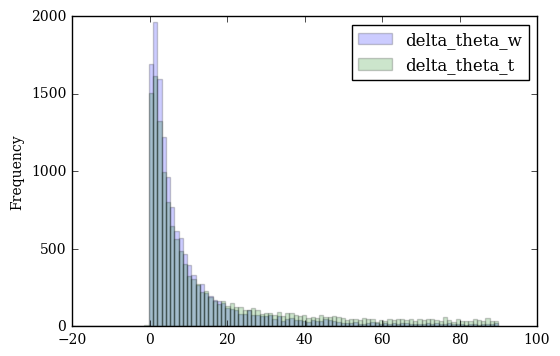

In [28]:
data[['delta_theta_w','delta_theta_t']].plot(kind='hist', bins=100, range=[-20,90], alpha=0.2)


# Tests

## find all events with low delta_theta for tailcuts, but high for wavelets (to see why!

In [29]:
badtheta = data[  
     (data['delta_theta_w'] > 15)
   & (data['delta_theta_t'] < 0.1) 
]
badtheta[['delta_theta_w','delta_theta_t']]


delta_theta_w  delta_theta_t
Tel ID Event ID                              
1      58000         16.588584      -1.107941
2      303907        48.943678       0.043827
11     311803        23.059150       0.033590
15     236900        23.479849     -14.323721
16     239400        15.365380       0.087931
25     26603         82.963337       0.048574
33     76900         21.919811       0.079847
       169001        21.515820      -0.169312

looking at all events: we conclude every one is a change coincidence where a single uncleaned pixel exists in the tailcuts that just so happens make the theta correct (but would be very bad if that pixels was not there).  

**Conclusion: no problem with wavelet method for this test**

## low vs high brightness: which is better theta?

In [30]:
# make some subsets for low and high brightness showers
data_lo = data[data['NPE_t'] < 1000]
data_hi = data[data['NPE_t'] > 5000]

(0, 50)

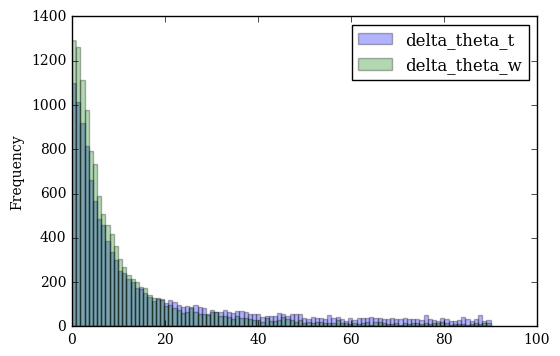

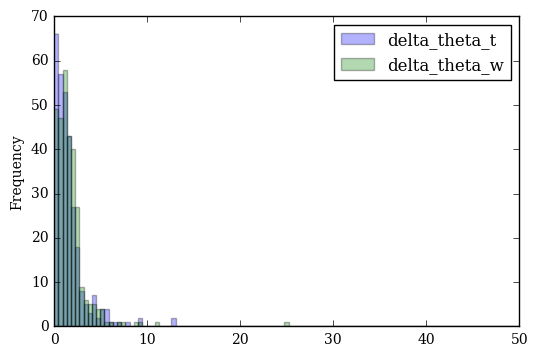

In [31]:

data_lo[['delta_theta_t','delta_theta_w']].plot.hist(range=(0,90), alpha=0.3,bins=100)
data_hi[['delta_theta_t','delta_theta_w']].plot.hist(range=(0,90), alpha=0.3,bins=200)
plt.xlim(0,50)


In [32]:
bad = data_hi[
   (data_hi['delta_theta_w']-data_hi['delta_theta_t']) > 3   

]

bad[['delta_theta_t','delta_theta_w']]

,,delta_theta_t,delta_theta_w
Tel ID,Event ID,,
7,438601,0.246372,4.976139
9,216501,3.889617,24.889524
32,26604,0.026130,4.303855
33,486801,0.052991,3.181532


## Some other random plots

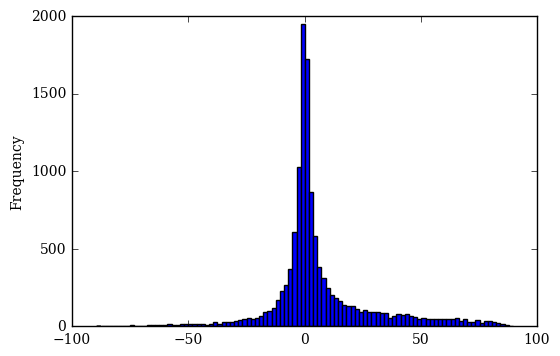

In [33]:
(data_lo['delta_theta_t'] - data_lo['delta_theta_w']).plot(kind='hist', bins=100)

(0, 20)

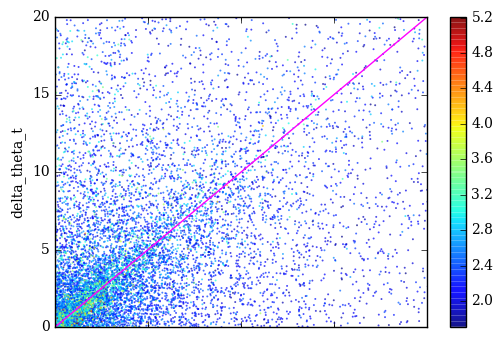

In [34]:
data.plot.scatter(x='delta_theta_w', y='delta_theta_t', 
                  c=np.log10(data['NPE_t']), 
                  lw=0, alpha=0.7, cmap='jet', s=2)
plt.plot(np.linspace(-5,90), np.linspace(-5,90),c='magenta')
plt.xlim(0,20)
plt.ylim(0,20)

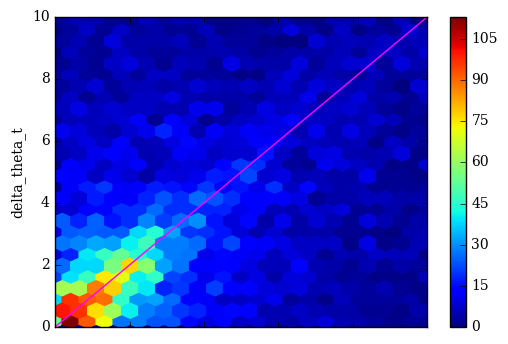

In [35]:
data.plot.hexbin(x='delta_theta_w', y='delta_theta_t', gridsize=250, cmap='jet')
plt.xlim(0,10)
plt.ylim(0,10)
plt.plot(np.linspace(-5,90), np.linspace(-5,90),c='magenta')

In [36]:
dd = data['delta_theta_t'] - data['delta_theta_w']

[]

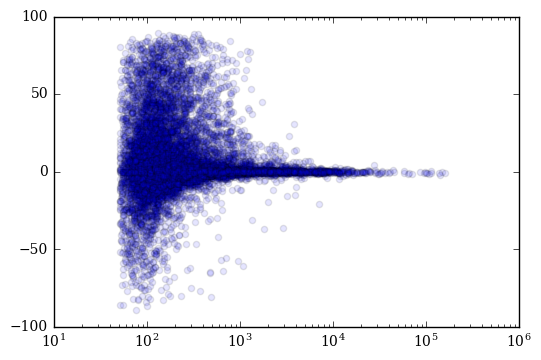

In [37]:
plt.scatter( data['NPE_t'], dd, alpha=0.1)
plt.semilogx()

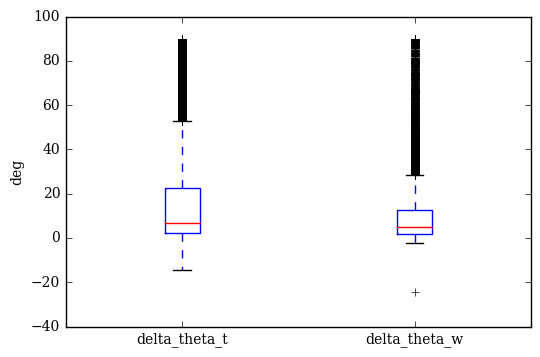

In [38]:
data[['delta_theta_t', 'delta_theta_w']].plot.box()
plt.ylabel('deg')

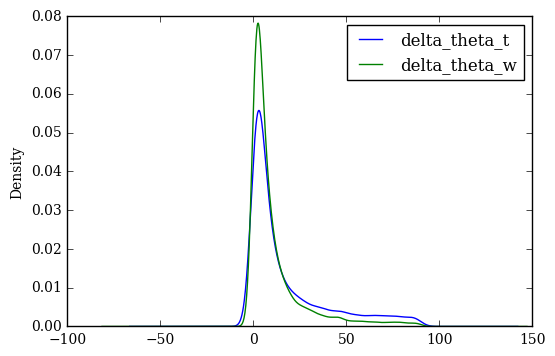

In [39]:
data[['delta_theta_t', 'delta_theta_w']].plot.density()

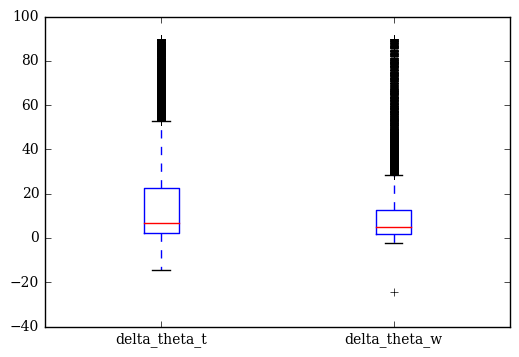

In [40]:
data[['delta_theta_t', 'delta_theta_w']].plot.box()

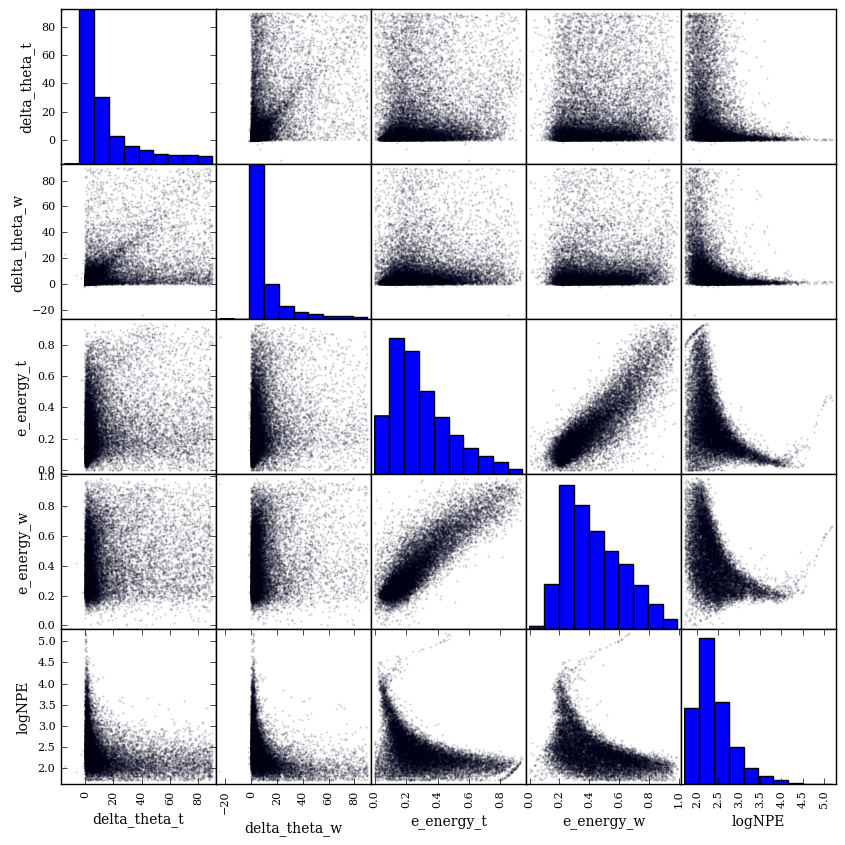

In [41]:
from pandas.tools.plotting import scatter_matrix
subset = data[['delta_theta_t', 'delta_theta_w', 'e_energy_t','e_energy_w',  'logNPE']]
ax = scatter_matrix(subset, s=1, alpha=0.2, figsize=(10,10))

In [42]:
subset.describe()

/Users/kosack/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,delta_theta_t,delta_theta_w,e_energy_t,e_energy_w,logNPE
count,14342.000000,14341.000000,14342.000000,14341.000000,14342.000000
mean,16.964327,11.140595,0.295416,0.434292,2.412236
std,21.891237,16.019599,0.190768,0.194691,0.461243
min,-14.323721,-24.255723,0.000031,0.000933,1.707570
25%,2.357541,NaN,0.151556,NaN,2.096910
50%,6.869390,NaN,0.247721,NaN,2.309630
75%,22.528397,NaN,0.399434,NaN,2.609594
max,89.979754,89.971894,0.938678,0.989473,5.205951
